In [1]:
from __future__ import print_function

%matplotlib inline

#basic op
import sys
import numpy as np
import pandas as pd
from collections import Counter
from time import time

#helper util to read data
from chai_deep_net.dna_reader import dna_to_onehot
from chai_deep_net.dna_reader import onehot_to_dna

#Karas
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K


#model adjustment
from sklearn.utils import class_weight

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#understand attribution
from deepexplain.tensorflow import DeepExplain



Using TensorFlow backend.


In [2]:
def keras_dna_model(input_shape):
    X_input = Input(input_shape)
    print(X_input.shape)
    X = Flatten()(X_input)
    X = Dense(6, activation='relu', name='n1')(X)
    X = Dense(1, activation='sigmoid', name='n2')(X)  
    model = Model(inputs=X_input, outputs=X, name='keras_dna_model')
    return model

In [5]:
pre_training_data = open('dataset/training_x').read().strip().split('\n')
X_train = np.expand_dims(np.array(map(np.transpose, map(dna_to_onehot, pre_training_data))), axis=4)
Y_train = np.expand_dims(np.array(map(float, open('dataset/training_y').read().strip().split('\n'))), axis=4)

pre_testing_data = open('dataset/test_x').read().strip().split('\n')
X_test = np.expand_dims(np.array(map(np.transpose, map(dna_to_onehot, pre_testing_data))), axis=4)
Y_test = np.expand_dims(np.array(map(float, open('dataset/test_y').read().strip().split('\n'))), axis=4)

print ("number of training examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 40000
X_train shape: (40000, 4, 12, 1)
Y_train shape: (40000, 1)
X_test shape: (20168, 4, 12, 1)
Y_test shape: (20168, 1)


In [9]:
input_dimension = X_train.shape[1:]
model = keras_dna_model(input_dimension)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#collect data in TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

#use weight to address imbalance sample
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.squeeze(Y_train, axis=1)),
                                                  np.squeeze(Y_train, axis=1))
print(class_weights)
class_weights = dict(enumerate(class_weights))

#fit(train) and save stat in history; callbacks = method to customize training which we ask it to use Tansorboard
history = model.fit(X_train, Y_train, epochs=10, batch_size=100, class_weight=class_weights,
                    validation_split=0.2, callbacks=[tensorboard])

(?, 4, 12, 1)
[ 0.97494394  1.02637791]
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 1s 30us/step - loss: 0.6594 - acc: 0.6112 - val_loss: 0.6193 - val_acc: 0.6804
Epoch 2/10
32000/32000 [==============================] - 1s 34us/step - loss: 0.6110 - acc: 0.6806 - val_loss: 0.5858 - val_acc: 0.7103
Epoch 3/10
32000/32000 [==============================] - 1s 30us/step - loss: 0.5832 - acc: 0.6994 - val_loss: 0.5631 - val_acc: 0.7223
Epoch 4/10
32000/32000 [==============================] - 1s 28us/step - loss: 0.5642 - acc: 0.7121 - val_loss: 0.5499 - val_acc: 0.7273
Epoch 5/10
32000/32000 [==============================] - 1s 29us/step - loss: 0.5521 - acc: 0.7172 - val_loss: 0.5410 - val_acc: 0.7311
Epoch 6/10
32000/32000 [==============================] - 1s 38us/step - loss: 0.5437 - acc: 0.7190 - val_loss: 0.5343 - val_acc: 0.7308
Epoch 7/10
32000/32000 [==============================] - 1s 31us/step - loss: 0.5382 - a

In [10]:
#use predict to sanitize check imbalance class
y_prob = model.predict(X_test)
rounded = [round(x[0]) for x in y_prob]
print(Counter(np.squeeze(Y_train)))
print(Counter(rounded))

#evaluation
preds = model.evaluate(X_test, Y_test, batch_size=20168, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))
#print model summary
model.summary()

# list all data in history
print(history.history.keys())

Counter({0.0: 20514, 1.0: 19486})
Counter({1.0: 11047, 0.0: 9121})
20168/20168 [==============================] - 0s 1us/step

Loss = 0.531195163727
Test Accuracy = 0.71444863081
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 12, 1)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 48)                0         
_________________________________________________________________
n1 (Dense)                   (None, 6)                 294       
_________________________________________________________________
n2 (Dense)                   (None, 1)                 7         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
['acc', 'loss', 'val_acc', 'val_loss']


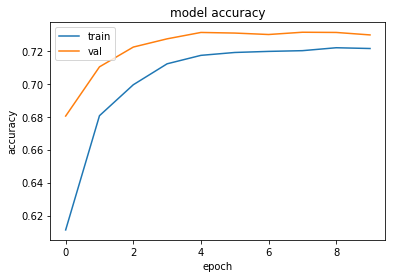

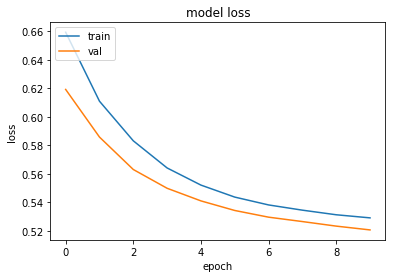

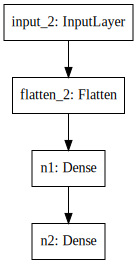

In [11]:
# summarize model performance
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Keras model visual
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# tensorflow visual
# RUN THIS: tensorboard --logdir=logs
# BROWSE THIS: http://0.0.0.0:6006

In [12]:
#https://github.com/marcoancona/DeepExplain
attribution_feature_input=X_test
attribution_response_input=Y_test
with DeepExplain(session=K.get_session()) as de:
    input_tensors = model.layers[0].input
    #input_tensors = model.inputs
    print('input_tensors shape2', type(input_tensors), input_tensors)
    fModel = Model(inputs=input_tensors, outputs=model.outputs)
    target_tensors = fModel(input_tensors)
    xs = attribution_feature_input
    ys = attribution_response_input
    #print('actual input',xs.shape, xs)
    #print('actual output',ys)
    attributions = de.explain('grad*input', target_tensors, input_tensors, xs)

input_tensors shape2 <class 'tensorflow.python.framework.ops.Tensor'> Tensor("input_2:0", shape=(?, 4, 12, 1), dtype=float32)
DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False


In [13]:
sum_attributions=np.sum(attributions,axis=0)
sum_attribution_feature_input=np.sum(attribution_feature_input,axis=0)
#print('sum_attributions',sum_attributions)
#print('sum_attribution_feature_input',sum_attribution_feature_input)
attribution_ratio=sum_attributions/sum_attribution_feature_input
#print('ratio',attribution_ratio)
attribution_ratio=attribution_ratio.squeeze(axis=2)
attribution_ratio=pd.DataFrame(attribution_ratio,index=list('ACGT'),columns=range(1,13))
print(attribution_ratio)



         1         2         3         4         5         6         7   \
A  0.039854  0.097857 -0.047280  0.105982  0.043372 -0.034982 -0.000510   
C  0.035692  0.019694  0.007644 -0.002362 -0.029198 -0.091650 -0.072226   
G  0.109521  0.035982  0.078836 -0.035220  0.013593 -0.120632 -0.040484   
T  0.039796  0.143300  0.010261  0.015218  0.017694 -0.043808  0.001965   

         8         9         10        11        12  
A  0.036207 -0.022842 -0.056138  0.054562  0.007108  
C -0.007079 -0.079981 -0.069825  0.004895  0.006086  
G  0.023945 -0.040635 -0.072883  0.012922  0.010718  
T  0.037073 -0.048502 -0.078587  0.042446  0.011957  


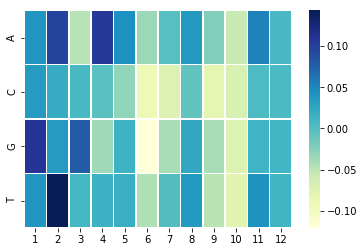

In [14]:
ax = sns.heatmap(attribution_ratio, linewidth=0.5,cmap="YlGnBu")
plt.show()